 # Train file 
 ---
 For the model we will start by showing that we can purely train on depths 1 and 2 as those are the first instances containing every possible block

## Shift in the overall goal of this project:
---
Originally this project started with the goal to combine two networks together to create stereoscopic images based on surrealist art. However, this process, while definitely possible through sets of linear translations and object degmentation, is impractical for real runtime arguments. So here in the notebooks we provide a proof of concept for the network, however we will be turning this into a script for the Blender and Maxwell tools for 3-D modelling

Blender: Construct a 3D set of objects in a constrained 3-D domain
Maxwell: Render these objects

For now we will focus on a proof of concept ProGAN, and from there we repurpose this gan for our script.

In [1]:
### - imports - ###
from PIL import Image
import numpy as np
import glob
import cv2 as cv
import os
import random
import argparse
### - other data augmentation imports - ### (if needed)
### - Imports - ###
import math
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from torchvision.datasets import ImageFolder
from NetworkMain import D, G
from tqdm import tqdm

Random Seed:  999


C:\Users\campb\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\campb\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#This code will be added later when the file is converted to a python file
"""parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./', help='directory contrains the data and outputs')
parser.add_argument('--epochs', type=int, default=40, help='training epoch number')
parser.add_argument('--out_res', type=int, default=128, help='The resolution of final output image')
parser.add_argument('--resume', type=int, default=0, help='continues from epoch number')
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')


opt = parser.parse_args()"""

root = '/Users/campb/Documents/PersonalProjects/AGRNet/'
data_dir = root + 'Dataset/'
check_point_dir = root + 'check_points/'
output_dir = root + 'output/'
weight_dir = root+ 'weight/'
if not os.path.exists(check_point_dir):
	os.makedirs(check_point_dir)
if not os.path.exists(output_dir):
	os.makedirs(output_dir)
if not os.path.exists(weight_dir):
	os.makedirs(weight_dir)

In [3]:
### - Global Variables - ###
DFP = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/Sample-'

img_folder = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/'

NS = '/Sample-'

image_format = 'RGB'

schedule = [[5, 15, 25 ,35, 40],[6, 5, 5, 5, 4],[5, 5, 5, 1, 1]] #Epochs for each cycle num of epochs

batch_size = schedule[1][0]

growing = schedule[2][0]

epochs = 40

latent_size = 512

out_res = 1024

lr = 1e-5

lambd = 10

In [4]:
device = T.device('cuda:0' if (T.cuda.is_available())  else 'cpu')

transform = transforms.Compose([
            transforms.Resize(out_res),
            transforms.CenterCrop(out_res),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
print(device)

cuda:0


In [5]:
#Create networks
Disc = None
Gen = None
Disc = D(latent_size, out_res).to(device)
Gen = G(latent_size, out_res).to(device)

In [6]:
#Noise for discriminator
fixed_noise = T.randn(16, latent_size, 1, 1).to(device)
#initialize optimizers
D_optimizer = optim.Adam(Disc.parameters(), lr=lr, betas=(0, 0.99))
G_optimizer = optim.Adam(Gen.parameters(), lr=lr, betas=(0, 0.99))
#Metric variables
D_running_loss = 0.0
G_running_loss = 0.0
iter_num = 0

D_epoch_losses = []
G_epoch_losses = []

In [7]:
#Load with ImageFolder wrapper
class ImageDataset(Dataset):
    def __init__(self,img_folder,names, transform):
        self.transform = transform
        self.image_names = names #Predetermined dataset
        self.img_folder=img_folder
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,index):
        image=Image.open(self.img_folder+self.image_names[index]).convert("RGB")
        image=self.transform(image)
        return image

assert(os.path.exists(DFP + str(1) + ".jpg"))
rawimgf = sorted(glob.glob(DFP + '*.jpg', recursive = True))
### - image names - ###
imnames = [i.split('/')[-1].split("t")[-1][1:] for i in rawimgf]

### - Global data loader Vars - ###
norms = (0.5,0.5,0.5), (0.5,0.5,0.5)
train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((out_res, out_res))])
# Parameters
params = {'batch_size': schedule[1][0],
          'shuffle': True,
         'num_workers': 0}

In [8]:
#Control variable
resume = 0
if resume != 0:
    check_point = T.load(check_point_dir+'check_point_epoch_%i.pth' % resume)
    fixed_noise = check_point['fixed_noise']
    G_net.load_state_dict(check_point['G_net'])
    D_net.load_state_dict(check_point['D_net'])
    G_optimizer.load_state_dict(check_point['G_optimizer'])
    D_optimizer.load_state_dict(check_point['D_optimizer'])
    G_epoch_losses = check_point['G_epoch_losses']
    D_epoch_losses = check_point['D_epoch_losses']
    G_net.depth = check_point['depth']
    D_net.depth = check_point['depth']
    G_net.alpha = check_point['alpha']
    D_net.alpha = check_point['alpha']



c = next(x[0] for x in enumerate(schedule[0]) if x[1]>resume)-1
batch_size = schedule[1][c]
growing = schedule[2][c]
dataset = ImageDataset(img_folder, imnames, train_transform)
# dataset = datasets.CelebA(data_dir, split='all', transform=transform)
data_loader = DataLoader(dataset, **params)

tot_iter_num = (len(dataset)/batch_size)
Gen.fade_iters = (1-Gen.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)
Disc.fade_iters = (1-Disc.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)

"""
except:
    print('Fully Grown\n')
    c = -1
    batch_size = schedule[1][c]
    growing = schedule[2][c]

    dataset = ImageDataset(img_folder,imnames, train_transform)
    data_loader = DataLoader(dataset, **params)

    tot_iter_num = (len(dataset)/batch_size)
    print(schedule[0][c], resume)

    if Gen.alpha < 1:
        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)
        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"""


"\nexcept:\n    print('Fully Grown\n')\n    c = -1\n    batch_size = schedule[1][c]\n    growing = schedule[2][c]\n\n    dataset = ImageDataset(img_folder,imnames, train_transform)\n    data_loader = DataLoader(dataset, **params)\n\n    tot_iter_num = (len(dataset)/batch_size)\n    print(schedule[0][c], resume)\n\n    if Gen.alpha < 1:\n        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)\n        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"

Output Resolution: 4 x 4
epoch: 1/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 3, 1024, 1024])


D_loss: 2.517   G_loss: 0.014:   4%|█▉                                                  | 1/27 [00:02<01:06,  2.57s/it]

tensor(0.0141, device='cuda:0', grad_fn=<NegBackward0>)
2.517120599746704 0.014149274677038193
2.517120599746704 0.014149274677038193
iteration : 0, gp: 2.76
torch.Size([6, 3, 1024, 1024])


D_loss: 2.517   G_loss: 0.014:   7%|███▊                                                | 2/27 [00:02<00:29,  1.17s/it]

tensor(0.0032, device='cuda:0', grad_fn=<NegBackward0>)
2.397303819656372 0.00320412777364254
2.397303819656372 0.00320412777364254
torch.Size([6, 3, 1024, 1024])
tensor(-0.0043, device='cuda:0', grad_fn=<NegBackward0>)
2.590686559677124 -0.0042752898298203945


D_loss: 2.517   G_loss: 0.014:  11%|█████▊                                              | 3/27 [00:02<00:17,  1.40it/s]

4.987990379333496 0.0074794176034629345
torch.Size([6, 3, 1024, 1024])
tensor(0.0004, device='cuda:0', grad_fn=<NegBackward0>)
2.0745949745178223 0.0004158372466918081


D_loss: 2.354   G_loss: 0.003:  15%|███████▋                                            | 4/27 [00:03<00:11,  1.98it/s]

7.062585353851318 0.007895254850154743
iteration : 3, gp: 2.47
torch.Size([6, 3, 1024, 1024])
tensor(0.0108, device='cuda:0', grad_fn=<NegBackward0>)
2.221562385559082 0.01082349568605423


D_loss: 2.354   G_loss: 0.003:  22%|███████████▌                                        | 6/27 [00:03<00:06,  3.18it/s]

2.221562385559082 0.01082349568605423
torch.Size([6, 3, 1024, 1024])
tensor(0.0073, device='cuda:0', grad_fn=<NegBackward0>)
2.25536847114563 0.0073342821560800076
4.476930856704712 0.018157777842134237


D_loss: 2.155   G_loss: 0.008:  26%|█████████████▍                                      | 7/27 [00:03<00:05,  3.70it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0059, device='cuda:0', grad_fn=<NegBackward0>)
1.9869530200958252 0.005885185208171606
6.463883876800537 0.024042963050305843
iteration : 6, gp: 2.30
torch.Size([6, 3, 1024, 1024])


D_loss: 2.155   G_loss: 0.008:  30%|███████████████▍                                    | 8/27 [00:03<00:04,  4.19it/s]

tensor(0.0129, device='cuda:0', grad_fn=<NegBackward0>)
2.2073190212249756 0.012888836674392223
2.2073190212249756 0.012888836674392223


D_loss: 2.155   G_loss: 0.008:  33%|█████████████████▎                                  | 9/27 [00:04<00:05,  3.43it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0034, device='cuda:0', grad_fn=<NegBackward0>)
2.1216187477111816 0.0034011187963187695
4.328937768936157 0.016289955470710993
torch.Size([6, 3, 1024, 1024])


D_loss: 2.010   G_loss: 0.011:  37%|██████████████████▉                                | 10/27 [00:04<00:04,  3.90it/s]

tensor(0.0174, device='cuda:0', grad_fn=<NegBackward0>)
1.7009754180908203 0.017415151000022888
6.0299131870269775 0.03370510647073388
iteration : 9, gp: 2.15
torch.Size([6, 3, 1024, 1024])
tensor(0.0069, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 2.010   G_loss: 0.011:  41%|████████████████████▊                              | 11/27 [00:04<00:03,  4.24it/s]

1.8452491760253906 0.006874982267618179
1.8452491760253906 0.006874982267618179
torch.Size([6, 3, 1024, 1024])
tensor(0.0002, device='cuda:0', grad_fn=<NegBackward0>)
1.8058335781097412 0.0002208004443673417


D_loss: 1.701   G_loss: 0.008:  48%|████████████████████████▌                          | 13/27 [00:04<00:02,  4.82it/s]

3.651082754135132 0.007095782711985521
torch.Size([6, 3, 1024, 1024])
tensor(0.0154, device='cuda:0', grad_fn=<NegBackward0>)
1.453214406967163 0.015425330959260464
5.104297161102295 0.022521113671245985
iteration : 12, gp: 1.95


D_loss: 1.701   G_loss: 0.008:  52%|██████████████████████████▍                        | 14/27 [00:05<00:02,  4.98it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0022, device='cuda:0', grad_fn=<NegBackward0>)
1.972428321838379 -0.002249613404273987
1.972428321838379 0.002249613404273987
torch.Size([6, 3, 1024, 1024])


D_loss: 1.701   G_loss: 0.008:  56%|████████████████████████████▎                      | 15/27 [00:05<00:02,  5.16it/s]

tensor(-0.0086, device='cuda:0', grad_fn=<NegBackward0>)
1.7103134393692017 -0.008631275035440922
3.6827417612075806 0.010880888439714909


D_loss: 1.805   G_loss: 0.006:  59%|██████████████████████████████▏                    | 16/27 [00:05<00:02,  3.88it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0074, device='cuda:0', grad_fn=<NegBackward0>)
1.7330912351608276 -0.007416766136884689
5.415832996368408 0.018297654576599598
iteration : 15, gp: 2.06
torch.Size([6, 3, 1024, 1024])


D_loss: 1.805   G_loss: 0.006:  63%|████████████████████████████████                   | 17/27 [00:05<00:02,  4.32it/s]

tensor(0.0184, device='cuda:0', grad_fn=<NegBackward0>)
1.4843090772628784 0.0183804202824831
1.4843090772628784 0.0183804202824831
torch.Size([6, 3, 1024, 1024])
tensor(0.0018, device='cuda:0', grad_fn=<NegBackward0>)
1.4106744527816772 0.0017607714980840683


D_loss: 1.805   G_loss: 0.006:  67%|██████████████████████████████████                 | 18/27 [00:06<00:01,  4.65it/s]

2.8949835300445557 0.02014119178056717
torch.Size([6, 3, 1024, 1024])
tensor(-0.0031, device='cuda:0', grad_fn=<NegBackward0>)
1.502502679824829 -0.0031376963015645742


D_loss: 1.466   G_loss: 0.008:  74%|█████████████████████████████████████▊             | 20/27 [00:06<00:01,  5.14it/s]

4.397486209869385 0.023278888082131743
iteration : 18, gp: 1.90
torch.Size([6, 3, 1024, 1024])
tensor(0.0006, device='cuda:0', grad_fn=<NegBackward0>)
1.4024752378463745 0.0005862405523657799
1.4024752378463745 0.0005862405523657799


D_loss: 1.466   G_loss: 0.008:  78%|███████████████████████████████████████▋           | 21/27 [00:06<00:01,  5.29it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0158, device='cuda:0', grad_fn=<NegBackward0>)
1.498886227607727 -0.015826212242245674
2.9013614654541016 0.016412452794611454


D_loss: 1.474   G_loss: 0.008:  81%|█████████████████████████████████████████▌         | 22/27 [00:06<00:00,  5.10it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0083, device='cuda:0', grad_fn=<NegBackward0>)
1.5215345621109009 0.008286409080028534
4.422896027565002 0.024698861874639988
iteration : 21, gp: 2.05
torch.Size([6, 3, 1024, 1024])


D_loss: 1.474   G_loss: 0.008:  85%|███████████████████████████████████████████▍       | 23/27 [00:07<00:00,  5.09it/s]

tensor(0.0098, device='cuda:0', grad_fn=<NegBackward0>)
1.3057650327682495 0.009794316254556179
1.3057650327682495 0.009794316254556179
torch.Size([6, 3, 1024, 1024])
tensor(0.0055, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.474   G_loss: 0.008:  89%|█████████████████████████████████████████████▎     | 24/27 [00:07<00:00,  5.16it/s]

1.2005424499511719 0.005488575901836157
2.5063074827194214 0.015282892156392336


D_loss: 1.171   G_loss: 0.008:  93%|███████████████████████████████████████████████▏   | 25/27 [00:07<00:00,  3.19it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0089, device='cuda:0', grad_fn=<NegBackward0>)
1.007169246673584 0.008860989473760128
3.5134767293930054 0.024143881630152464
iteration : 24, gp: 1.53
torch.Size([6, 3, 1024, 1024])


D_loss: 1.171   G_loss: 0.008:  96%|█████████████████████████████████████████████████  | 26/27 [00:07<00:00,  3.67it/s]

tensor(-0.0058, device='cuda:0', grad_fn=<NegBackward0>)
1.0007572174072266 -0.005777986720204353
1.0007572174072266 0.005777986720204353
torch.Size([5, 3, 1024, 1024])
tensor(0.0192, device='cuda:0', grad_fn=<NegBackward0>)
1.1527493000030518 0.019166618585586548


D_loss: 1.171   G_loss: 0.008: 100%|███████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.31it/s]


2.1535065174102783 0.0249446053057909
epoch: 2/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0157, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.983   G_loss: 0.014:   4%|█▉                                                  | 1/27 [00:00<00:05,  5.03it/s]

0.7942667007446289 -0.015694307163357735
2.9477732181549072 0.040638912469148636
iteration : 0, gp: 1.29
torch.Size([6, 3, 1024, 1024])
tensor(-0.0021, device='cuda:0', grad_fn=<NegBackward0>)
0.9406530261039734 -0.0021468920167535543


D_loss: 0.983   G_loss: 0.014:   7%|███▊                                                | 2/27 [00:00<00:04,  5.29it/s]

0.9406530261039734 0.0021468920167535543
torch.Size([6, 3, 1024, 1024])
tensor(-0.0086, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.983   G_loss: 0.014:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.34it/s]

0.47459614276885986 -0.008594905026257038
1.4152491688728333 0.010741797043010592


D_loss: 0.798   G_loss: 0.004:  15%|███████▋                                            | 4/27 [00:00<00:06,  3.74it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0005, device='cuda:0', grad_fn=<NegBackward0>)
0.9787142276763916 -0.0005318938638083637
2.393963396549225 0.011273690906818956
iteration : 3, gp: 1.49
torch.Size([6, 3, 1024, 1024])


D_loss: 0.798   G_loss: 0.004:  19%|█████████▋                                          | 5/27 [00:01<00:05,  4.23it/s]

tensor(0.0139, device='cuda:0', grad_fn=<NegBackward0>)
0.9116165041923523 0.013889022171497345
0.9116165041923523 0.013889022171497345
torch.Size([6, 3, 1024, 1024])
tensor(0.0071, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.798   G_loss: 0.004:  22%|███████████▌                                        | 6/27 [00:01<00:04,  4.52it/s]

0.6750528812408447 0.007054920308291912
1.586669385433197 0.020943942479789257
torch.Size([6, 3, 1024, 1024])
tensor(-0.0143, device='cuda:0', grad_fn=<NegBackward0>)
0.6858922839164734 -0.014331369660794735


D_loss: 0.758   G_loss: 0.012:  26%|█████████████▍                                      | 7/27 [00:01<00:04,  4.77it/s]

2.2725616693496704 0.03527531214058399
iteration : 6, gp: 1.45
torch.Size([6, 3, 1024, 1024])
tensor(-0.0166, device='cuda:0', grad_fn=<NegBackward0>)
0.45686012506484985 -0.01660393737256527


D_loss: 0.758   G_loss: 0.012:  33%|█████████████████▎                                  | 9/27 [00:01<00:03,  5.21it/s]

0.45686012506484985 0.01660393737256527
torch.Size([6, 3, 1024, 1024])
tensor(-0.0211, device='cuda:0', grad_fn=<NegBackward0>)
0.3694012761116028 -0.02111893892288208
0.8262614011764526 0.03772287629544735


D_loss: 0.463   G_loss: 0.016:  37%|██████████████████▉                                | 10/27 [00:02<00:03,  5.35it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0100, device='cuda:0', grad_fn=<NegBackward0>)
0.5631599426269531 -0.010049054399132729
1.3894213438034058 0.04777193069458008
iteration : 9, gp: 1.33


D_loss: 0.463   G_loss: 0.016:  41%|████████████████████▊                              | 11/27 [00:02<00:04,  3.47it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0018, device='cuda:0', grad_fn=<NegBackward0>)
0.7912785410881042 0.001828555716201663
0.7912785410881042 0.001828555716201663
torch.Size([6, 3, 1024, 1024])

D_loss: 0.463   G_loss: 0.016:  44%|██████████████████████▋                            | 12/27 [00:02<00:03,  3.88it/s]


tensor(0.0061, device='cuda:0', grad_fn=<NegBackward0>)
0.5404071807861328 0.006062644533813
1.331685721874237 0.007891200250014663
torch.Size([6, 3, 1024, 1024])


D_loss: 0.543   G_loss: 0.005:  48%|████████████████████████▌                          | 13/27 [00:02<00:03,  4.26it/s]

tensor(-0.0059, device='cuda:0', grad_fn=<NegBackward0>)
0.29751700162887573 -0.0058983187191188335
1.6292027235031128 0.013789518969133496
iteration : 12, gp: 0.99
torch.Size([6, 3, 1024, 1024])
tensor(-0.0129, device='cuda:0', grad_fn=<NegBackward0>)
0.7332534790039062 -0.012857767753303051


D_loss: 0.543   G_loss: 0.005:  56%|████████████████████████████▎                      | 15/27 [00:03<00:02,  4.92it/s]

0.7332534790039062 0.012857767753303051
torch.Size([6, 3, 1024, 1024])
tensor(-0.0115, device='cuda:0', grad_fn=<NegBackward0>)
0.6447030901908875 -0.01153117697685957
1.3779565691947937 0.02438894473016262


D_loss: 0.494   G_loss: 0.018:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:02,  5.11it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0309, device='cuda:0', grad_fn=<NegBackward0>)
-0.10419875383377075 -0.030895134434103966
1.4821553230285645 0.055284079164266586
iteration : 15, gp: 0.78


D_loss: 0.494   G_loss: 0.018:  63%|████████████████████████████████                   | 17/27 [00:03<00:02,  4.07it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0288, device='cuda:0', grad_fn=<NegBackward0>)
0.09776628017425537 -0.028760530054569244
0.09776628017425537 0.028760530054569244
torch.Size([6, 3, 1024, 1024])


D_loss: 0.494   G_loss: 0.018:  67%|██████████████████████████████████                 | 18/27 [00:04<00:02,  4.37it/s]

tensor(-0.0207, device='cuda:0', grad_fn=<NegBackward0>)
0.5012036561965942 -0.02066016010940075
0.5989699363708496 0.049420690163969994
torch.Size([6, 3, 1024, 1024])
tensor(-0.0064, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.278   G_loss: 0.019:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  4.98it/s]

0.23495137691497803 -0.006392030976712704
0.8339213132858276 0.0558127211406827
iteration : 18, gp: 1.03
torch.Size([6, 3, 1024, 1024])
tensor(-0.0094, device='cuda:0', grad_fn=<NegBackward0>)
0.5936465263366699 -0.00943625159561634
0.5936465263366699 0.00943625159561634


D_loss: 0.278   G_loss: 0.019:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  5.11it/s]

torch.Size([6, 3, 1024, 1024])
tensor(0.0058, device='cuda:0', grad_fn=<NegBackward0>)
0.32591092586517334 0.0058432770892977715
0.9195574522018433 0.015279528684914112
torch.Size([6, 3, 1024, 1024])


D_loss: 0.307   G_loss: 0.006:  81%|█████████████████████████████████████████▌         | 22/27 [00:04<00:00,  5.23it/s]

tensor(-0.0036, device='cuda:0', grad_fn=<NegBackward0>)
-0.0004870295524597168 -0.0035938385408371687
0.920044481754303 0.01887336722575128
iteration : 21, gp: 0.63
torch.Size([6, 3, 1024, 1024])
tensor(-0.0192, device='cuda:0', grad_fn=<NegBackward0>)
0.06001859903335571 -0.019226137548685074


D_loss: 0.307   G_loss: 0.006:  89%|█████████████████████████████████████████████▎     | 24/27 [00:05<00:00,  5.52it/s]

0.06001859903335571 0.019226137548685074
torch.Size([6, 3, 1024, 1024])
tensor(-0.0306, device='cuda:0', grad_fn=<NegBackward0>)
0.13484948873519897 -0.030609391629695892
0.1948680877685547 0.049835529178380966


D_loss: 0.094   G_loss: 0.019:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  5.27it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0076, device='cuda:0', grad_fn=<NegBackward0>)
-0.0877847671508789 -0.007639299146831036
0.2826528549194336 0.057474828325212
iteration : 24, gp: 0.64
torch.Size([6, 3, 1024, 1024])


D_loss: 0.094   G_loss: 0.019:  96%|█████████████████████████████████████████████████  | 26/27 [00:05<00:00,  5.32it/s]

tensor(-0.0254, device='cuda:0', grad_fn=<NegBackward0>)
-0.20363277196884155 -0.02536802366375923
0.20363277196884155 0.02536802366375923
torch.Size([5, 3, 1024, 1024])
tensor(-0.0372, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.094   G_loss: 0.019: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.79it/s]

-0.2607399821281433 -0.03722069039940834
0.46437275409698486 0.06258871406316757


epoch: 3/40


D_loss: 0.164   G_loss: 0.027:   4%|█▉                                                  | 1/27 [00:00<00:04,  5.81it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0175, device='cuda:0', grad_fn=<NegBackward0>)
0.02651149034500122 -0.017496909946203232
0.4908842444419861 0.0800856240093708
iteration : 0, gp: 0.62
torch.Size([6, 3, 1024, 1024])


D_loss: 0.164   G_loss: 0.027:   7%|███▊                                                | 2/27 [00:00<00:04,  5.85it/s]

tensor(-0.0041, device='cuda:0', grad_fn=<NegBackward0>)
-0.24529272317886353 -0.004149945452809334
0.24529272317886353 0.004149945452809334
torch.Size([6, 3, 1024, 1024])
tensor(-0.0371, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.164   G_loss: 0.027:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.53it/s]

-0.3427291512489319 -0.03712830692529678
0.5880218744277954 0.04127825237810612
torch.Size([6, 3, 1024, 1024])
tensor(-0.0233, device='cuda:0', grad_fn=<NegBackward0>)
-0.38722264766693115 -0.023266371339559555


D_loss: 0.325   G_loss: 0.022:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.65it/s]

0.9752445220947266 0.06454462371766567
iteration : 3, gp: 0.60


D_loss: 0.325   G_loss: 0.022:  19%|█████████▋                                          | 5/27 [00:01<00:06,  3.30it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0159, device='cuda:0', grad_fn=<NegBackward0>)
-0.1468697190284729 -0.0158645398914814
0.1468697190284729 0.0158645398914814
torch.Size([6, 3, 1024, 1024])


D_loss: 0.325   G_loss: 0.022:  22%|███████████▌                                        | 6/27 [00:01<00:05,  3.85it/s]

tensor(-0.0075, device='cuda:0', grad_fn=<NegBackward0>)
-0.4960694909095764 -0.007453670725226402
0.6429392099380493 0.023318210616707802


D_loss: 0.458   G_loss: 0.012:  26%|█████████████▍                                      | 7/27 [00:01<00:05,  3.40it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0123, device='cuda:0', grad_fn=<NegBackward0>)
-0.7321799993515015 -0.0123384278267622
1.3751192092895508 0.03565663844347
iteration : 6, gp: 0.55
torch.Size([6, 3, 1024, 1024])


D_loss: 0.458   G_loss: 0.012:  30%|███████████████▍                                    | 8/27 [00:01<00:04,  3.84it/s]

tensor(-0.0313, device='cuda:0', grad_fn=<NegBackward0>)
-0.6102369427680969 -0.03128586709499359
0.6102369427680969 0.03128586709499359
torch.Size([6, 3, 1024, 1024])
tensor(-0.0288, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.458   G_loss: 0.012:  33%|█████████████████▎                                  | 9/27 [00:02<00:04,  4.18it/s]

-0.7423413395881653 -0.028818853199481964
1.3525782823562622 0.060104720294475555
torch.Size([6, 3, 1024, 1024])
tensor(-0.0138, device='cuda:0', grad_fn=<NegBackward0>)
-0.3709830045700073 -0.01376914232969284


D_loss: 0.575   G_loss: 0.025:  37%|██████████████████▉                                | 10/27 [00:02<00:03,  4.55it/s]

1.7235612869262695 0.0738738626241684
iteration : 9, gp: 0.48
torch.Size([6, 3, 1024, 1024])
tensor(-0.0293, device='cuda:0', grad_fn=<NegBackward0>)
-0.1079704761505127

D_loss: 0.575   G_loss: 0.025:  44%|██████████████████████▋                            | 12/27 [00:02<00:02,  5.03it/s]

 -0.029284395277500153
0.1079704761505127 0.029284395277500153
torch.Size([6, 3, 1024, 1024])
tensor(-0.0078, device='cuda:0', grad_fn=<NegBackward0>)
-0.47756433486938477 -0.007791813462972641
0.5855348110198975 0.037076208740472794


D_loss: 0.250   G_loss: 0.024:  48%|████████████████████████▌                          | 13/27 [00:02<00:02,  5.25it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0336, device='cuda:0', grad_fn=<NegBackward0>)
-0.16370755434036255 -0.033589377999305725
0.74924236536026 0.07066558673977852
iteration : 12, gp: 0.62
torch.Size([6, 3, 1024, 1024])


D_loss: 0.250   G_loss: 0.024:  52%|██████████████████████████▍                        | 14/27 [00:03<00:02,  5.43it/s]

tensor(-0.0204, device='cuda:0', grad_fn=<NegBackward0>)
-0.6490954160690308 -0.020400527864694595
0.6490954160690308 0.020400527864694595
torch.Size([6, 3, 1024, 1024])
tensor(-0.0575, device='cuda:0', grad_fn=<NegBackward0>)
-0.6734372973442078 -0.05752237141132355


D_loss: 0.250   G_loss: 0.024:  56%|████████████████████████████▎                      | 15/27 [00:03<00:02,  5.59it/s]

1.3225327134132385 0.07792289927601814
torch.Size([6, 3, 1024, 1024])
tensor(-0.0417, device='cuda:0', grad_fn=<NegBackward0>)
-0.3032245635986328 -0.04170674830675125


D_loss: 0.542   G_loss: 0.040:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:01,  5.57it/s]

1.6257572770118713 0.1196296475827694
iteration : 15, gp: 0.44


D_loss: 0.542   G_loss: 0.040:  63%|████████████████████████████████                   | 17/27 [00:03<00:02,  4.14it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0309, device='cuda:0', grad_fn=<NegBackward0>)
-1.0286853313446045 -0.030889956280589104
1.0286853313446045 0.030889956280589104


D_loss: 0.542   G_loss: 0.040:  67%|██████████████████████████████████                 | 18/27 [00:03<00:02,  4.30it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0322, device='cuda:0', grad_fn=<NegBackward0>)
-0.3083707392215729 -0.03219446912407875
1.3370560705661774 0.06308442540466785
torch.Size([6, 3, 1024, 1024])


D_loss: 0.606   G_loss: 0.028:  70%|███████████████████████████████████▉               | 19/27 [00:04<00:01,  4.61it/s]

tensor(-0.0198, device='cuda:0', grad_fn=<NegBackward0>)
-0.4812157154083252 -0.019796375185251236
1.8182717859745026 0.08288080058991909
iteration : 18, gp: 0.54
torch.Size([6, 3, 1024, 1024])
tensor(-0.0362, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 0.606   G_loss: 0.028:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  5.08it/s]

-1.0290210247039795 -0.03620237484574318
1.0290210247039795 0.03620237484574318
torch.Size([6, 3, 1024, 1024])
tensor(-0.0276, device='cuda:0', grad_fn=<NegBackward0>)
-0.327836275100708 -0.02756187878549099
1.3568572998046875 0.06376425363123417


D_loss: 0.782   G_loss: 0.034:  81%|█████████████████████████████████████████▌         | 22/27 [00:04<00:00,  5.11it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0381, device='cuda:0', grad_fn=<NegBackward0>)
-0.9884240627288818 -0.03809394687414169
2.3452813625335693 0.10185820050537586
iteration : 21, gp: 0.30
torch.Size([6, 3, 1024, 1024])


D_loss: 0.782   G_loss: 0.034:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:00,  5.25it/s]

tensor(-0.0280, device='cuda:0', grad_fn=<NegBackward0>)
-0.8729021549224854 -0.02802242338657379
0.8729021549224854 0.02802242338657379
torch.Size([6, 3, 1024, 1024])
tensor(-0.0410, device='cuda:0', grad_fn=<NegBackward0>)
-0.8470416069030762 -0.04101109504699707


D_loss: 0.807   G_loss: 0.035:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  5.43it/s]

1.7199437618255615 0.06903351843357086
torch.Size([6, 3, 1024, 1024])
tensor(-0.0367, device='cuda:0', grad_fn=<NegBackward0>)
-0.7005056738853455 -0.03665071725845337
2.420449435710907 0.10568423569202423
iteration : 24, gp: 0.48


D_loss: 0.807   G_loss: 0.035:  96%|█████████████████████████████████████████████████  | 26/27 [00:05<00:00,  5.64it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0441, device='cuda:0', grad_fn=<NegBackward0>)
-0.9697874188423157 -0.04409092664718628
0.9697874188423157 0.04409092664718628
torch.Size([5, 3, 1024, 1024])


D_loss: 0.807   G_loss: 0.035: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.84it/s]

tensor(-0.0812, device='cuda:0', grad_fn=<NegBackward0>)
-0.9027512669563293 -0.08123379945755005
1.872538685798645 0.12532472610473633


epoch: 4/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0258, device='cuda:0', grad_fn=<NegBackward0>)
-0.8954769372940063 -0.025804486125707626


D_loss: 0.923   G_loss: 0.050:   4%|█▉                                                  | 1/27 [00:00<00:04,  5.32it/s]

2.7680156230926514 0.15112921223044395
iteration : 0, gp: 0.23
torch.Size([6, 3, 1024, 1024])
tensor(-0.0697, device='cuda:0', grad_fn=<NegBackward0>)
-0.8879451751708984 -0.06969670951366425


D_loss: 0.923   G_loss: 0.050:   7%|███▊                                                | 2/27 [00:00<00:04,  5.46it/s]

0.8879451751708984 0.06969670951366425
torch.Size([6, 3, 1024, 1024])
tensor(-0.0193, device='cuda:0', grad_fn=<NegBackward0>)
-1.1497352123260498 -0.01934688724577427


D_loss: 0.923   G_loss: 0.050:  11%|█████▊                                              | 3/27 [00:00<00:04,  5.63it/s]

2.0376803874969482 0.08904359675943851
torch.Size([6, 3, 1024, 1024])
tensor(-0.0403, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.132   G_loss: 0.043:  15%|███████▋                                            | 4/27 [00:00<00:04,  5.19it/s]

-1.3575412034988403 -0.040317684412002563
3.3952215909957886 0.12936128117144108
iteration : 3, gp: 0.17
torch.Size([6, 3, 1024, 1024])


D_loss: 1.132   G_loss: 0.043:  19%|█████████▋                                          | 5/27 [00:00<00:04,  5.41it/s]

tensor(-0.0523, device='cuda:0', grad_fn=<NegBackward0>)
-1.064640760421753 -0.052321016788482666
1.064640760421753 0.052321016788482666
torch.Size([6, 3, 1024, 1024])
tensor(-0.0277, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.132   G_loss: 0.043:  22%|███████████▌                                        | 6/27 [00:01<00:03,  5.48it/s]

-1.2885063886642456 -0.02766539715230465
2.3531471490859985 0.07998641394078732
torch.Size([6, 3, 1024, 1024])


D_loss: 1.188   G_loss: 0.048:  26%|█████████████▍                                      | 7/27 [00:01<00:03,  5.61it/s]

tensor(-0.0639, device='cuda:0', grad_fn=<NegBackward0>)
-1.2121249437332153 -0.06392262876033783
3.565272092819214 0.14390904270112514
iteration : 6, gp: 0.20


D_loss: 1.188   G_loss: 0.048:  30%|███████████████▍                                    | 8/27 [00:01<00:04,  4.03it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0306, device='cuda:0', grad_fn=<NegBackward0>)
-1.4414620399475098 -0.030620485544204712
1.4414620399475098 0.030620485544204712
torch.Size([6, 3, 1024, 1024])


D_loss: 1.188   G_loss: 0.048:  33%|█████████████████▎                                  | 9/27 [00:01<00:04,  4.44it/s]

tensor(-0.0384, device='cuda:0', grad_fn=<NegBackward0>)
-0.918484091758728 -0.038438715040683746
2.359946131706238 0.06905920058488846
torch.Size([6, 3, 1024, 1024])
tensor(-0.0541, device='cuda:0', grad_fn=<NegBackward0>)
-1.2503083944320679 -0.05405833572149277


D_loss: 1.203   G_loss: 0.041:  41%|████████████████████▊                              | 11/27 [00:02<00:03,  5.10it/s]

3.6102545261383057 0.12311753630638123
iteration : 9, gp: 0.10
torch.Size([6, 3, 1024, 1024])
tensor(-0.0602, device='cuda:0', grad_fn=<NegBackward0>)
-1.4425166845321655 -0.06024759262800217
1.4425166845321655 0.06024759262800217


D_loss: 1.203   G_loss: 0.041:  44%|██████████████████████▋                            | 12/27 [00:02<00:02,  5.24it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0650, device='cuda:0', grad_fn=<NegBackward0>)
-1.3850271701812744 -0.06504425406455994
2.82754385471344 0.1252918466925621
torch.Size([6, 3, 1024, 1024])


D_loss: 1.348   G_loss: 0.078:  48%|████████████████████████▌                          | 13/27 [00:02<00:02,  5.37it/s]

tensor(-0.1084, device='cuda:0', grad_fn=<NegBackward0>)
-1.2170664072036743 -0.10835979878902435
4.044610261917114 0.23365164548158646
iteration : 12, gp: 0.20


D_loss: 1.348   G_loss: 0.078:  52%|██████████████████████████▍                        | 14/27 [00:03<00:03,  3.44it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0840, device='cuda:0', grad_fn=<NegBackward0>)
-1.0878257751464844 -0.08403582870960236
1.0878257751464844 0.08403582870960236


D_loss: 1.348   G_loss: 0.078:  56%|████████████████████████████▎                      | 15/27 [00:03<00:03,  3.67it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0722, device='cuda:0', grad_fn=<NegBackward0>)
-1.0647413730621338 -0.0721992775797844
2.152567148208618 0.15623510628938675
torch.Size([6, 3, 1024, 1024])


D_loss: 1.076   G_loss: 0.066:  59%|██████████████████████████████▏                    | 16/27 [00:03<00:02,  4.07it/s]

tensor(-0.0419, device='cuda:0', grad_fn=<NegBackward0>)
-1.0743318796157837 -0.04187559336423874
3.226899027824402 0.1981106996536255
iteration : 15, gp: 0.18
torch.Size([6, 3, 1024, 1024])
tensor(-0.0771, device='cuda:0', grad_fn=<NegBackward0>)
-1.1504875421524048 -0.07713121175765991


D_loss: 1.076   G_loss: 0.066:  67%|██████████████████████████████████                 | 18/27 [00:03<00:01,  4.69it/s]

1.1504875421524048 0.07713121175765991
torch.Size([6, 3, 1024, 1024])
tensor(-0.0548, device='cuda:0', grad_fn=<NegBackward0>)
-1.3118342161178589 -0.0548127219080925
2.4623217582702637 0.1319439336657524


D_loss: 1.156   G_loss: 0.074:  70%|███████████████████████████████████▉               | 19/27 [00:04<00:01,  4.91it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0894, device='cuda:0', grad_fn=<NegBackward0>)
-1.0061675310134888 -0.089361272752285
3.4684892892837524 0.22130520641803741
iteration : 18, gp: 0.21
torch.Size([6, 3, 1024, 1024])


D_loss: 1.156   G_loss: 0.074:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  5.01it/s]

tensor(-0.0658, device='cuda:0', grad_fn=<NegBackward0>)
-1.2173864841461182 -0.06576568633317947
1.2173864841461182 0.06576568633317947
torch.Size([6, 3, 1024, 1024])
tensor(-0.0832, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.156   G_loss: 0.074:  78%|███████████████████████████████████████▋           | 21/27 [00:04<00:01,  5.08it/s]

-1.3252652883529663 -0.08321737498044968
2.5426517724990845 0.14898306131362915
torch.Size([6, 3, 1024, 1024])
tensor(-0.0683, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.259   G_loss: 0.072:  85%|███████████████████████████████████████████▍       | 23/27 [00:04<00:00,  5.23it/s]

-1.2347233295440674 -0.06832359731197357
3.777375102043152 0.21730665862560272
iteration : 21, gp: 0.03
torch.Size([6, 3, 1024, 1024])
tensor(-0.0803, device='cuda:0', grad_fn=<NegBackward0>)
-1.782508373260498 -0.08027058094739914
1.782508373260498 0.08027058094739914


D_loss: 1.259   G_loss: 0.072:  89%|█████████████████████████████████████████████▎     | 24/27 [00:05<00:00,  3.98it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0722, device='cuda:0', grad_fn=<NegBackward0>)
-1.256859540939331 -0.07220879942178726
3.039367914199829 0.1524793803691864
torch.Size([6, 3, 1024, 1024])


D_loss: 1.395   G_loss: 0.072:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  4.39it/s]

tensor(-0.0637, device='cuda:0', grad_fn=<NegBackward0>)
-1.146657943725586 -0.06373940408229828
4.186025857925415 0.21621878445148468
iteration : 24, gp: 0.03
torch.Size([6, 3, 1024, 1024])
tensor(-0.0606, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.395   G_loss: 0.072: 100%|███████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.74it/s]


-1.8419785499572754 -0.06064377352595329
1.8419785499572754 0.06064377352595329
torch.Size([5, 3, 1024, 1024])
tensor(-0.0917, device='cuda:0', grad_fn=<NegBackward0>)
-1.473251223564148 -0.09170735627412796
3.3152297735214233 0.15235112980008125
epoch: 5/40


  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

torch.Size([6, 3, 1024, 1024])


D_loss: 1.547   G_loss: 0.085:   4%|█▉                                                  | 1/27 [00:00<00:10,  2.58it/s]

tensor(-0.1018, device='cuda:0', grad_fn=<NegBackward0>)
-1.3264713287353516 -0.10180070996284485
4.641701102256775 0.2541518397629261
iteration : 0, gp: 0.08


D_loss: 1.547   G_loss: 0.085:   7%|███▊                                                | 2/27 [00:00<00:08,  2.95it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0455, device='cuda:0', grad_fn=<NegBackward0>)
-1.3029742240905762 -0.04551006108522415
1.3029742240905762 0.04551006108522415


D_loss: 1.547   G_loss: 0.085:  11%|█████▊                                              | 3/27 [00:00<00:07,  3.39it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.1044, device='cuda:0', grad_fn=<NegBackward0>)
-1.496852159500122 -0.10442139953374863
2.7998263835906982 0.14993146061897278
torch.Size([6, 3, 1024, 1024])


D_loss: 1.376   G_loss: 0.088:  15%|███████▋                                            | 4/27 [00:01<00:05,  4.00it/s]

tensor(-0.1137, device='cuda:0', grad_fn=<NegBackward0>)
-1.3269197940826416 -0.11374905705451965
4.12674617767334 0.26368051767349243
iteration : 3, gp: 0.15


D_loss: 1.376   G_loss: 0.088:  19%|█████████▋                                          | 5/27 [00:01<00:06,  3.33it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.1010, device='cuda:0', grad_fn=<NegBackward0>)
-1.3399043083190918 -0.10097336769104004
1.3399043083190918 0.10097336769104004
torch.Size([6, 3, 1024, 1024])


D_loss: 1.376   G_loss: 0.088:  22%|███████████▌                                        | 6/27 [00:01<00:05,  3.87it/s]

tensor(-0.0840, device='cuda:0', grad_fn=<NegBackward0>)
-2.0517828464508057 -0.08395769447088242
3.3916871547698975 0.18493106216192245
torch.Size([6, 3, 1024, 1024])
tensor(-0.1089, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.697   G_loss: 0.098:  26%|█████████████▍                                      | 7/27 [00:01<00:04,  4.23it/s]

-1.6989902257919312 -0.10887273401021957
5.090677380561829 0.29380379617214203
iteration : 6, gp: 0.21
torch.Size([6, 3, 1024, 1024])
tensor(-0.0933, device='cuda:0', grad_fn=<NegBackward0>)
-0.9268351793289185 -0.09330256283283234


D_loss: 1.697   G_loss: 0.098:  30%|███████████████▍                                    | 8/27 [00:02<00:04,  4.60it/s]

0.9268351793289185 0.09330256283283234


D_loss: 1.697   G_loss: 0.098:  33%|█████████████████▎                                  | 9/27 [00:02<00:04,  3.83it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0926, device='cuda:0', grad_fn=<NegBackward0>)
-1.9007779359817505 -0.09259479492902756
2.827613115310669 0.1858973577618599
torch.Size([6, 3, 1024, 1024])


D_loss: 1.338   G_loss: 0.096:  37%|██████████████████▉                                | 10/27 [00:02<00:04,  4.16it/s]

tensor(-0.1036, device='cuda:0', grad_fn=<NegBackward0>)
-1.1865489482879639 -0.103561632335186
4.014162063598633 0.2894589900970459
iteration : 9, gp: 0.13


D_loss: 1.338   G_loss: 0.096:  41%|████████████████████▊                              | 11/27 [00:03<00:05,  2.87it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.0888, device='cuda:0', grad_fn=<NegBackward0>)
-1.4679242372512817 -0.08877421915531158
1.4679242372512817 0.08877421915531158
torch.Size([6, 3, 1024, 1024])


D_loss: 1.338   G_loss: 0.096:  44%|██████████████████████▋                            | 12/27 [00:03<00:04,  3.35it/s]

tensor(-0.1054, device='cuda:0', grad_fn=<NegBackward0>)
-1.5529632568359375 -0.10536898672580719
3.0208874940872192 0.19414320588111877
torch.Size([6, 3, 1024, 1024])
tensor(-0.1602, device='cuda:0', grad_fn=<NegBackward0>)
-1.8848485946655273 -0.1602039635181427


D_loss: 1.635   G_loss: 0.118:  48%|████████████████████████▌                          | 13/27 [00:03<00:03,  3.79it/s]

4.905736088752747 0.3543471693992615
iteration : 12, gp: 0.01
torch.Size([6, 3, 1024, 1024])
tensor(-0.1266, device='cuda:0', grad_fn=<NegBackward0>)
-2.0144691467285156 -0.1266307234764099


D_loss: 1.635   G_loss: 0.118:  52%|██████████████████████████▍                        | 14/27 [00:03<00:03,  4.17it/s]

2.0144691467285156 0.1266307234764099
torch.Size([6, 3, 1024, 1024])
tensor(-0.1144, device='cuda:0', grad_fn=<NegBackward0>)
-1.665942907333374 -0.11443985998630524


D_loss: 1.635   G_loss: 0.118:  56%|████████████████████████████▎                      | 15/27 [00:03<00:02,  4.51it/s]

3.6804120540618896 0.24107058346271515
torch.Size([6, 3, 1024, 1024])
tensor(-0.1152, device='cuda:0', grad_fn=<NegBackward0>)
-1.688489317893982 -0.1151890978217125


D_loss: 1.790   G_loss: 0.119:  59%|██████████████████████████████▏                    | 16/27 [00:04<00:02,  4.68it/s]

5.368901371955872 0.35625968128442764
iteration : 15, gp: 0.01
torch.Size([6, 3, 1024, 1024])
tensor(-0.1389, device='cuda:0', grad_fn=<NegBackward0>)
-1.935836911201477 -0.13885848224163055


D_loss: 1.790   G_loss: 0.119:  63%|████████████████████████████████                   | 17/27 [00:04<00:02,  4.83it/s]

1.935836911201477 0.13885848224163055
torch.Size([6, 3, 1024, 1024])
tensor(-0.1111, device='cuda:0', grad_fn=<NegBackward0>)
-1.702176809310913 -0.1110701784491539


D_loss: 1.790   G_loss: 0.119:  67%|██████████████████████████████████                 | 18/27 [00:04<00:01,  4.92it/s]

3.63801372051239 0.24992866069078445
torch.Size([6, 3, 1024, 1024])
tensor(-0.1097, device='cuda:0', grad_fn=<NegBackward0>)
-2.027752161026001 -0.10967403650283813


D_loss: 1.889   G_loss: 0.120:  74%|█████████████████████████████████████▊             | 20/27 [00:04<00:01,  5.09it/s]

5.665765881538391 0.3596026971936226
iteration : 18, gp: 0.02
torch.Size([6, 3, 1024, 1024])
tensor(-0.1387, device='cuda:0', grad_fn=<NegBackward0>)
-1.3422296047210693 -0.13869115710258484
1.3422296047210693 0.13869115710258484


D_loss: 1.889   G_loss: 0.120:  78%|███████████████████████████████████████▋           | 21/27 [00:05<00:01,  5.16it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.1223, device='cuda:0', grad_fn=<NegBackward0>)
-1.975158452987671 -0.1222807988524437
3.3173880577087402 0.26097195595502853
torch.Size([6, 3, 1024, 1024])


D_loss: 1.743   G_loss: 0.112:  81%|█████████████████████████████████████████▌         | 22/27 [00:05<00:00,  5.30it/s]

tensor(-0.0762, device='cuda:0', grad_fn=<NegBackward0>)
-1.9104019403457642 -0.07619179785251617
5.227789998054504 0.3371637538075447
iteration : 21, gp: 0.01
torch.Size([6, 3, 1024, 1024])
tensor(-0.1285, device='cuda:0', grad_fn=<NegBackward0>)


D_loss: 1.743   G_loss: 0.112:  89%|█████████████████████████████████████████████▎     | 24/27 [00:05<00:00,  5.46it/s]

-1.5780794620513916 -0.12848882377147675
1.5780794620513916 0.12848882377147675
torch.Size([6, 3, 1024, 1024])
tensor(-0.1297, device='cuda:0', grad_fn=<NegBackward0>)
-1.5361084938049316 -0.12967678904533386
3.1141879558563232 0.2581656128168106


D_loss: 1.731   G_loss: 0.121:  93%|███████████████████████████████████████████████▏   | 25/27 [00:05<00:00,  5.44it/s]

torch.Size([6, 3, 1024, 1024])
tensor(-0.1046, device='cuda:0', grad_fn=<NegBackward0>)
-2.078054189682007 -0.10464662313461304
5.19224214553833 0.36281223595142365
iteration : 24, gp: 0.02
torch.Size([6, 3, 1024, 1024])


D_loss: 1.731   G_loss: 0.121:  96%|█████████████████████████████████████████████████  | 26/27 [00:05<00:00,  5.40it/s]

tensor(-0.1500, device='cuda:0', grad_fn=<NegBackward0>)
-1.9523249864578247 -0.14996542036533356
1.9523249864578247 0.14996542036533356
torch.Size([5, 3, 1024, 1024])
tensor(-0.1191, device='cuda:0', grad_fn=<NegBackward0>)
-1.820766806602478 -0.11912160366773605


D_loss: 1.731   G_loss: 0.121: 100%|███████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.38it/s]

3.7730917930603027 0.2690870240330696


AttributeError: 'G' object has no attribute 'growing_net'

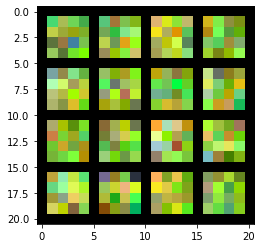

In [9]:
### - Train Loop - ###
size = 2**(Gen.depth+1)
print("Output Resolution: %d x %d" % (size, size))
for epoch in range(1+resume, epochs+1):
    Gen.train()
    D_epoch_loss = 0.0
    G_epoch_loss = 0.0
    if epoch-1 in schedule[0]:

        if (2 **(Gen.depth +1) < out_res):
            c = schedule[0].index(epoch-1)
            batch_size = schedule[1][c]
            growing = schedule[2][0]
            data_loader = DataLoader(dataset, **params)
            tot_iter_num = tot_iter_num = (len(dataset)/batch_size)
            Gen.growing_net(growing*tot_iter_num)
            Disc.growing_net(growing*tot_iter_num)
            size = 2**(Gen.depth+1)
            print("Output Resolution: %d x %d" % (size, size))

	
    print("epoch: %i/%i" % (int(epoch), int(epochs)))
    databar = tqdm(data_loader)
    for i, samples in enumerate(databar):
        print(samples.shape)
        ##  update D
        if size != out_res: #Basically need to, A Reshape, B prepare the data for the networks
            samples = F.interpolate(samples, size=(size,size)).to(device)
        else:
            samples = samples.to(device)
        Disc.zero_grad()
        noise = T.randn(samples.size(0), latent_size, 1, 1, device=device)
        fake = Gen(noise)
        #out_grid = make_grid(fake, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        #plt.imshow(out_grid.cpu())
        fake_out = Disc(fake.detach())
        real_out = Disc(samples)
        ## Gradient Penalty
        
        eps = T.rand(samples.size(0), 1, 1, 1, device=device)
        eps = eps.expand_as(Gen(noise))
        x_hat = eps * samples + (1 - eps) * fake.detach()
        x_hat.requires_grad = True
        px_hat = Disc(x_hat)
        grad = T.autograd.grad(
                                    outputs = px_hat.sum(),
                                    inputs = x_hat, 
                                    create_graph=True
                                    )[0]
        grad_norm = grad.view(samples.size(0), -1).norm(2, dim=1)
        gradient_penalty = lambd * ((grad_norm  - 1)**2).mean()
        ###########

        D_loss = fake_out.mean() - real_out.mean() + gradient_penalty
        D_loss.backward()
        D_optimizer.step()

        ##	update G

        Gen.zero_grad()
        fake_out = Disc(fake)

        G_loss = - fake_out.mean()
        print(G_loss)
        G_loss.backward()
        G_optimizer.step()

        ##############
        print(D_loss.item(), G_loss.item())
        D_running_loss += abs(D_loss.item())
        G_running_loss += abs(G_loss.item())
        print(D_running_loss,G_running_loss)
        iter_num += 1
        if i % 3== 0:
            D_running_loss /= iter_num
            G_running_loss /= iter_num
            print('iteration : %d, gp: %.2f' % (i, gradient_penalty))
            databar.set_description('D_loss: %.3f   G_loss: %.3f' % (D_running_loss ,G_running_loss))
            iter_num = 0
            D_running_loss = 0.0
            G_running_loss = 0.0


    D_epoch_losses.append(D_epoch_loss/tot_iter_num)
    G_epoch_losses.append(G_epoch_loss/tot_iter_num)


    check_point = {'G_net' : Gen.state_dict(), 
                   'G_optimizer' : G_optimizer.state_dict(),
                   'D_net' : Disc.state_dict(),
                   'D_optimizer' : D_optimizer.state_dict(),
                   'D_epoch_losses' : D_epoch_losses,
                   'G_epoch_losses' : G_epoch_losses,
                   'fixed_noise': fixed_noise,
                   'depth': Gen.depth,
                   'alpha':Gen.alpha
                   }
    with T.no_grad():
        Gen.eval()
        T.save(check_point, check_point_dir + 'check_point_epoch_%d.pth' % (epoch))
        T.save(Gen.state_dict(), weight_dir + 'G_weight_epoch_%d.pth' %(epoch))
        out_imgs = Gen(fixed_noise).to(device)
        out_grid = make_grid(out_imgs, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        plt.imshow(out_grid.cpu())
        plt.savefig(output_dir + 'size_%i_epoch_%d' %(size ,epoch))